In [1]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.


In [2]:
from datetime import datetime as dt
from pytz import timezone
import pytz
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv1D, Conv2D, BatchNormalization, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, Dropout
from tensorflow.keras import Model

from boto3_utilities import *

In [3]:
print(tf.__version__)

2.4.3


In [4]:
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [5]:
BUCKET_NAME = "sensor-data-keisuke-nakata"

# Load from S3

In [6]:
df_rest = read_s3_file(BUCKET_NAME, "sample=256/label=rest/latest/data.csv")
df_rest.head()

,dt,grp,cnt,sample,emg,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label
0,2021/10/12 16:31:21,0,0,256,3.000978,0.012085,0.033325,0.980957,1.770020,1.281738,0.854492,rest
1,2021/10/12 16:31:21,0,1,256,3.093842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,rest
2,2021/10/12 16:31:21,0,2,256,3.010753,0.013550,0.033447,0.979492,1.525879,1.464844,0.854492,rest
3,2021/10/12 16:31:21,0,3,256,3.069404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,rest
4,2021/10/12 16:31:21,0,4,256,3.005865,0.013184,0.033203,0.979980,1.586914,1.342773,0.854492,rest


In [7]:
df_touch = read_s3_file("sensor-data-keisuke-nakata", "sample=256/label=touch/latest/data.csv")
df_touch.head()

,dt,grp,cnt,sample,emg,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label
0,2021/10/12 16:15:49,0,0,256,3.866080,0.021851,0.034668,0.978027,1.647949,1.708984,0.915527,touch
1,2021/10/12 16:15:49,0,1,256,3.768328,0.020508,0.036987,0.974365,1.831055,1.525879,0.915527,touch
2,2021/10/12 16:15:49,0,2,256,3.841642,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,touch
3,2021/10/12 16:15:49,0,3,256,3.817204,0.020630,0.035156,0.974365,2.014160,1.342773,0.976562,touch
4,2021/10/12 16:15:49,0,4,256,3.778104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,touch


# Preprocess

In [8]:
rest_list = df_rest.groupby("grp")["emg"].apply(list)
df_rest_emg = pd.DataFrame(rest_list).reset_index()['emg']

df_rest_emg = pd.DataFrame(df_rest_emg.values.tolist())
df_rest_emg.columns = [f'{i * 5}' for i in range(0, len(df_rest_emg.columns))]
df_rest_emg['label'] = 'rest'

print(len(df_rest_emg))
df_rest_emg.head()

106


,0,5,10,15,20,25,30,35,40,45,...,1235,1240,1245,1250,1255,1260,1265,1270,1275,label
0,3.000978,3.093842,3.010753,3.069404,3.005865,3.079179,3.030303,2.981427,3.088954,3.005865,...,3.035191,3.064516,3.010753,3.098729,3.088954,3.040078,3.079179,3.010753,3.084066,rest
1,4.584555,4.628543,4.613881,4.589443,4.608993,4.594330,4.506354,4.579668,4.393939,4.545455,...,3.929619,3.797654,3.724340,3.528837,3.543499,3.607038,3.582600,3.621701,3.479961,rest
2,3.235582,3.054741,3.172043,3.103617,3.079179,3.118279,3.059628,3.049853,3.020528,3.069404,...,3.079179,2.991202,3.049853,3.069404,2.991202,3.064516,3.010753,2.996090,3.040078,rest
3,3.064516,2.908113,2.908113,3.074291,2.996090,3.025415,3.103617,3.035191,3.084066,3.049853,...,3.054741,3.074291,3.005865,3.123167,3.098729,3.084066,3.255132,3.132942,3.176931,rest
4,3.123167,3.181818,3.157380,3.113392,3.172043,3.054741,3.167156,3.137830,3.069404,3.181818,...,3.103617,3.074291,3.123167,3.064516,3.118279,3.118279,3.079179,3.118279,3.079179,rest


In [9]:
touch_list = df_touch.groupby("grp")["emg"].apply(list)
df_touch_emg = pd.DataFrame(touch_list).reset_index()['emg']

df_touch_emg = pd.DataFrame(df_touch_emg.values.tolist())
df_touch_emg.columns = [f'{i * 5}' for i in range(0, len(df_touch_emg.columns))]
df_touch_emg['label'] = 'touch'

print(len(df_touch_emg))
df_touch_emg.head()

86


,0,5,10,15,20,25,30,35,40,45,...,1235,1240,1245,1250,1255,1260,1265,1270,1275,label
0,3.866080,3.768328,3.841642,3.817204,3.778104,3.822092,3.714565,3.831867,3.778104,3.768328,...,3.665689,3.616813,3.563050,3.690127,3.567937,3.641251,3.651026,3.607038,3.636364,touch
1,3.636364,3.714565,3.651026,3.651026,3.690127,3.616813,3.719453,3.651026,3.670577,3.724340,...,3.880743,3.973607,3.954057,3.880743,3.973607,3.880743,3.949169,3.929619,3.866080,touch
2,3.954057,3.831867,3.910069,3.890518,3.861192,3.905181,3.822092,3.958944,3.939394,3.880743,...,3.988270,3.949169,3.856305,3.968719,3.870968,3.910069,3.914956,3.890518,3.998045,touch
3,3.245357,3.123167,3.186706,3.396872,3.421310,3.499511,3.421310,3.318671,3.504399,3.445748,...,2.922776,3.015640,2.956989,2.913001,2.961877,2.883676,2.976540,2.971652,2.932551,touch
4,3.651026,3.553275,3.597263,3.558162,3.680352,3.660802,3.602150,3.812317,3.631476,3.714565,...,3.817204,3.724340,3.807429,3.768328,3.753666,3.807429,3.719453,3.802541,3.748778,touch


In [10]:
data_size = min(len(df_rest_emg), len(df_touch_emg))
df_rest_emg_cut = df_rest_emg[:data_size-1]
df_touch_emg_cut = df_touch_emg[:data_size-1]

# merge
df_emg = pd.concat([df_rest_emg_cut, df_touch_emg_cut], axis=0)
df_emg.head()

,0,5,10,15,20,25,30,35,40,45,...,1235,1240,1245,1250,1255,1260,1265,1270,1275,label
0,3.000978,3.093842,3.010753,3.069404,3.005865,3.079179,3.030303,2.981427,3.088954,3.005865,...,3.035191,3.064516,3.010753,3.098729,3.088954,3.040078,3.079179,3.010753,3.084066,rest
1,4.584555,4.628543,4.613881,4.589443,4.608993,4.594330,4.506354,4.579668,4.393939,4.545455,...,3.929619,3.797654,3.724340,3.528837,3.543499,3.607038,3.582600,3.621701,3.479961,rest
2,3.235582,3.054741,3.172043,3.103617,3.079179,3.118279,3.059628,3.049853,3.020528,3.069404,...,3.079179,2.991202,3.049853,3.069404,2.991202,3.064516,3.010753,2.996090,3.040078,rest
3,3.064516,2.908113,2.908113,3.074291,2.996090,3.025415,3.103617,3.035191,3.084066,3.049853,...,3.054741,3.074291,3.005865,3.123167,3.098729,3.084066,3.255132,3.132942,3.176931,rest
4,3.123167,3.181818,3.157380,3.113392,3.172043,3.054741,3.167156,3.137830,3.069404,3.181818,...,3.103617,3.074291,3.123167,3.064516,3.118279,3.118279,3.079179,3.118279,3.079179,rest


In [11]:
# separate label
df_emg_label = df_emg['label']
df_emg = df_emg.drop("label", axis=1)

df_emg.head()

,0,5,10,15,20,25,30,35,40,45,...,1230,1235,1240,1245,1250,1255,1260,1265,1270,1275
0,3.000978,3.093842,3.010753,3.069404,3.005865,3.079179,3.030303,2.981427,3.088954,3.005865,...,3.054741,3.035191,3.064516,3.010753,3.098729,3.088954,3.040078,3.079179,3.010753,3.084066
1,4.584555,4.628543,4.613881,4.589443,4.608993,4.594330,4.506354,4.579668,4.393939,4.545455,...,4.076246,3.929619,3.797654,3.724340,3.528837,3.543499,3.607038,3.582600,3.621701,3.479961
2,3.235582,3.054741,3.172043,3.103617,3.079179,3.118279,3.059628,3.049853,3.020528,3.069404,...,2.952102,3.079179,2.991202,3.049853,3.069404,2.991202,3.064516,3.010753,2.996090,3.040078
3,3.064516,2.908113,2.908113,3.074291,2.996090,3.025415,3.103617,3.035191,3.084066,3.049853,...,3.147605,3.054741,3.074291,3.005865,3.123167,3.098729,3.084066,3.255132,3.132942,3.176931
4,3.123167,3.181818,3.157380,3.113392,3.172043,3.054741,3.167156,3.137830,3.069404,3.181818,...,3.152493,3.103617,3.074291,3.123167,3.064516,3.118279,3.118279,3.079179,3.118279,3.079179


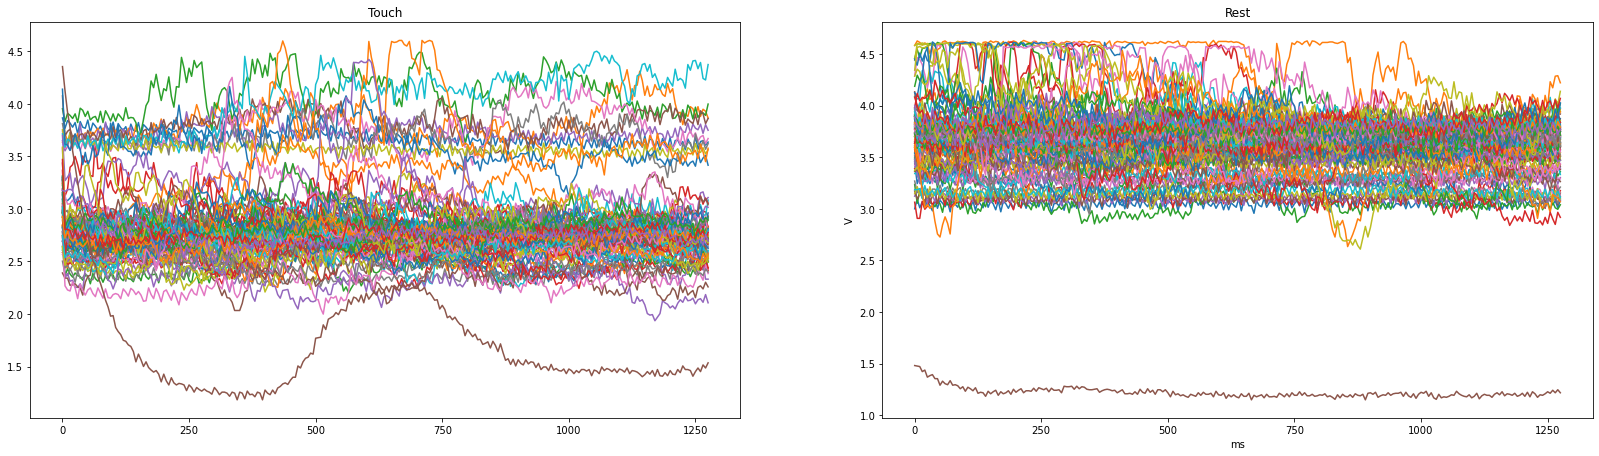

In [12]:
fig = plt.figure(figsize=(28, 16))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

df_touch_emg.drop("label", axis=1).T.plot(ax=ax1, label='touch')
df_rest_emg.drop("label", axis=1).T.plot(ax=ax2, label='rest')

ax1.set_title('Touch', loc='center')
ax2.set_title('Rest', loc='center')

ax1.get_legend().remove()
ax2.get_legend().remove()

plt.xlabel('ms')
plt.ylabel('V')
plt.show()

# Standraization

In [13]:
# scaler = StandardScaler()
# scaler.fit(df_emg)
# scaler.transform(df_emg)
# df_emg_std= pd.DataFrame(scaler.transform(df_emg), columns=df_emg.columns)

# arr_emg_data = df_emg_std.values
# print(arr_emg_data)

In [14]:
arr_emg_data = df_emg.values
print(arr_emg_data)

[[3.000978 3.093842 3.010753 ... 3.079179 3.010753 3.084066]
 [4.584555 4.628543 4.613881 ... 3.5826   3.621701 3.479961]
 [3.235582 3.054741 3.172043 ... 3.010753 2.99609  3.040078]
 ...
 [3.313783 2.820137 2.888563 ... 2.869013 2.917889 2.893451]
 [3.470186 2.805474 2.805474 ... 2.790811 2.71261  2.776149]
 [3.176931 3.167156 3.181818 ... 2.653959 2.756598 2.69306 ]]


# Label Encoding

In [15]:
# category transform
le = LabelEncoder()
arr_emg_label = le.fit_transform(df_emg_label)
arr_emg_label = np.array(list(map(lambda x:np.array([int(x)]), arr_emg_label)))

# Split Data

In [16]:
windowsize = 256

arr_emg_data = arr_emg_data.astype('float32')
x_train, x_test, y_train, y_test = train_test_split(arr_emg_data, arr_emg_label, stratify=df_emg_label)

x_train = x_train.reshape(x_train.shape[0], windowsize, 1, 1)
x_test = x_test.reshape(x_test.shape[0], windowsize, 1, 1)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(127, 256, 1, 1) (43, 256, 1, 1)
(127, 1) (43, 1)


# Training

## VGG16

In [17]:
# model = Sequential()

# model.add(Conv2D(filters=64, kernel_size=(3, 1), activation='relu', padding="same", name='block1_conv1', input_shape=(windowsize, 1, 1)))
# model.add(Conv2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same', name='block1_conv2'))
# model.add(MaxPooling2D(padding='same', name='block1_pool'))

# model.add(Conv2D(filters=128, kernel_size=(3, 1), activation='relu', padding="same", name='block2_conv1'))
# model.add(Conv2D(filters=128, kernel_size=(3, 1), activation='relu', padding='same', name='block2_conv2'))
# model.add(MaxPooling2D(padding='same', name='block2_pool'))

# model.add(Conv2D(filters=256, kernel_size=(3, 1), activation='relu', padding="same", name='block3_conv1'))
# model.add(Conv2D(filters=256, kernel_size=(3, 1), activation='relu', padding='same', name='block3_conv2'))
# model.add(Conv2D(filters=256, kernel_size=(3, 1), activation='relu', padding='same', name='block3_conv3'))
# model.add(MaxPooling2D(padding='same', name='block3_pool'))

# model.add(Conv2D(filters=512, kernel_size=(3, 1), activation='relu', padding="same", name='block4_conv1'))
# model.add(Conv2D(filters=512, kernel_size=(3, 1), activation='relu', padding='same', name='block4_conv2'))
# model.add(Conv2D(filters=512, kernel_size=(3, 1), activation='relu', padding='same', name='block4_conv3'))
# model.add(MaxPooling2D(padding='same', name='block4_pool'))

# model.add(Conv2D(filters=512, kernel_size=(3, 1), activation='relu', padding="same", name='block5_conv1'))
# model.add(Conv2D(filters=512, kernel_size=(3, 1), activation='relu', padding='same', name='block5_conv2'))
# model.add(Conv2D(filters=512, kernel_size=(3, 1), activation='relu', padding='same', name='block5_conv3'))
# model.add(MaxPooling2D(padding='same', name='block5_pool'))

# model.add(Flatten(name='flatten'))
# model.add(Dense(units=4096, activation='relu', name='fc1'))
# model.add(Dropout(0.5, name='dropout1'))
# model.add(Dense(units=4096, activation='relu', name='fc2'))
# model.add(Dropout(0.5, name='dropout2'))

# model.add(Dense(units=2, activation='softmax', name='predictions'))


# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='acc')
# model.summary()

# VGG8

In [18]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 1), padding="same", name='block1_conv1', input_shape=(windowsize, 1, 1)))
model.add(BatchNormalization(name='block1_bn'))
model.add(Activation('relu', name='block1_act'))
model.add(MaxPooling2D(padding='same', name='block1_pool'))

model.add(Conv2D(filters=16, kernel_size=(3, 1), padding="same", name='block2_conv1'))
model.add(BatchNormalization(name='block2_bn'))
model.add(Activation('relu', name='block2_act'))

model.add(Conv2D(filters=32, kernel_size=(3, 1), padding="same", name='block3_conv1'))
model.add(BatchNormalization(name='block3_bn'))
model.add(Activation('relu', name='block3_act'))
model.add(MaxPooling2D(padding='same', name='block3_pool'))

model.add(Conv2D(filters=32, kernel_size=(3, 1), padding="same", name='block4_conv1'))
model.add(BatchNormalization(name='block4_bn'))
model.add(Activation('relu', name='block4_act'))

model.add(Conv2D(filters=64, kernel_size=(3, 1), padding="same", name='block5_conv1'))
model.add(BatchNormalization(name='block5_bn'))
model.add(Activation('relu', name='block5_act'))
model.add(MaxPooling2D(padding='same', name='block5_pool'))

model.add(Conv2D(filters=64, kernel_size=(3, 1), padding="same", name='block6_conv1'))
model.add(BatchNormalization(name='block6_bn'))
model.add(Activation('relu', name='block6_act'))

model.add(Conv2D(filters=128, kernel_size=(3, 1), padding="same", name='block7_conv1'))
model.add(BatchNormalization(name='block7_bn'))
model.add(Activation('relu', name='block7_act'))
model.add(MaxPooling2D(padding='same', name='block7_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(units=128, activation='relu', name='fc1'))
model.add(Dropout(0.5, name='dropout1'))

model.add(Dense(units=2, activation='softmax', name='predictions'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='acc')
model.summary()

Extension horovod.torch has not been built: /home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-10-22 16:15:02.237 ip-172-16-57-184.ap-northeast-1.compute.internal:15708 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-10-22 16:15:02.266 ip-172-16-57-184.ap-northeast-1.compute.internal:15708 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 256, 1, 16)        64        
_________________________________________________________________
block1_

In [19]:
epochs = 100
history = model.fit(x_train, y_train, epochs = 100, batch_size = 128)
model.save(MODEL_TF)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.8600 - acc: 0.5906
Epoch 2/100
1/1 [==============================] - 0s 99ms/step - loss: 1.3252 - acc: 0.7244
Epoch 3/100
1/1 [==============================] - 0s 103ms/step - loss: 0.3804 - acc: 0.9134
Epoch 4/100
1/1 [==============================] - 0s 101ms/step - loss: 0.4228 - acc: 0.8031
Epoch 5/100
1/1 [==============================] - 0s 103ms/step - loss: 0.3492 - acc: 0.8504
Epoch 6/100
1/1 [==============================] - 0s 104ms/step - loss: 0.2567 - acc: 0.8740
Epoch 7/100
1/1 [==============================] - 0s 103ms/step - loss: 0.2228 - acc: 0.9370
Epoch 8/100
1/1 [==============================] - 0s 104ms/step - loss: 0.2517 - acc: 0.9291
Epoch 9/100
1/1 [==============================] - 0s 101ms/step - loss: 0.2121 - acc: 0.9213
Epoch 10/100
1/1 [==============================] - 0s 101ms/step - loss: 0.1456 - acc: 0.9449
Epoch 11/100
1/1 [==============================] - 0s 103ms/st

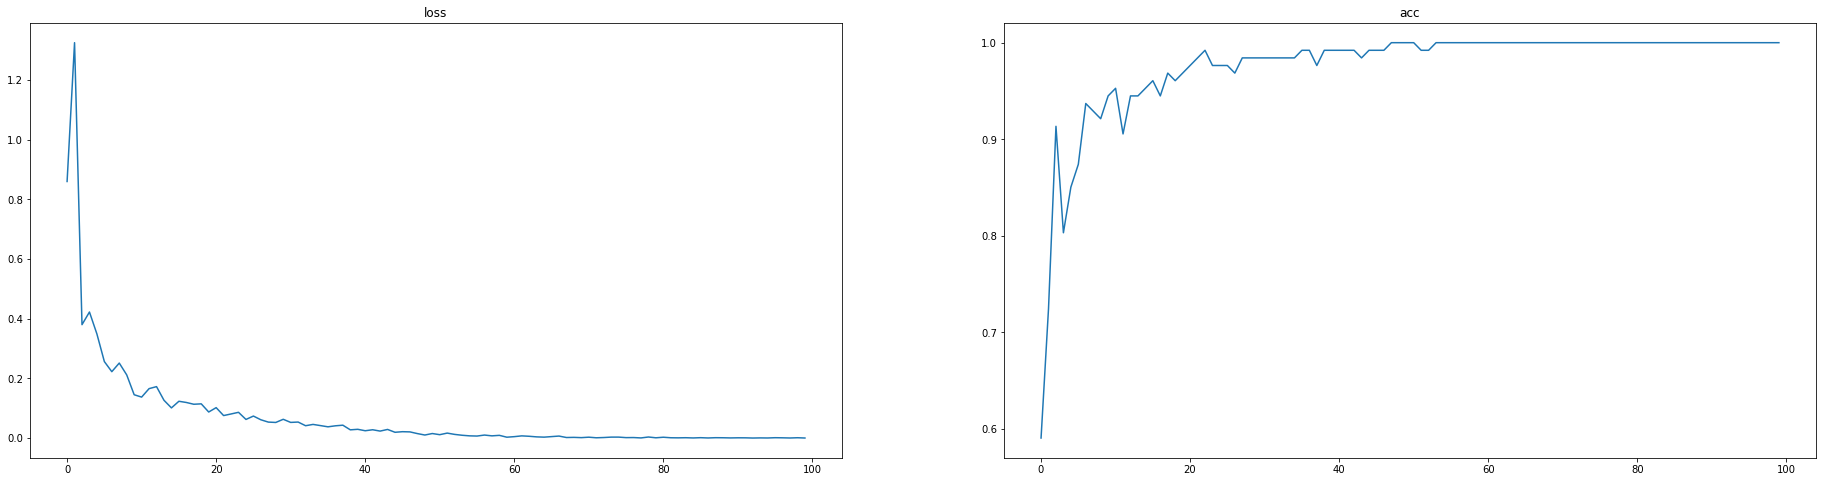

In [20]:
fig = plt.figure(figsize=(32, 8))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


ax1.plot(range(epochs), history.history['loss'], label='loss')
ax2.plot(range(epochs), history.history['acc'], label='acc')

ax1.set_title('loss')
ax2.set_title('acc')

plt.show()

# Convert to TF Lite model

## 1. Generate Models with Quantization

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)

# Convert the model to the TensorFlow Lite format without quantization
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)



# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield [x_train.astype(np.float32)]

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

330328

## 2. Compare Model Performance

In [22]:
# def predict_tflite(tflite_model, x_test):
#   # Prepare the test data
#   x_test_ = x_test.copy()
#   x_test_ = x_test_.reshape((x_test.size, 1))
#   x_test_ = x_test_.astype(np.float32)

#   # Initialize the TFLite interpreter
#   interpreter = tf.lite.Interpreter(model_content=tflite_model)
#   interpreter.allocate_tensors()

#   input_details = interpreter.get_input_details()[0]
#   output_details = interpreter.get_output_details()[0]

#   # If required, quantize the input layer (from float to integer)
#   input_scale, input_zero_point = input_details["quantization"]
#   if (input_scale, input_zero_point) != (0.0, 0):
#     x_test_ = x_test_ / input_scale + input_zero_point
#     x_test_ = x_test_.astype(input_details["dtype"])
  
#   # Invoke the interpreter
#   y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
#   for i in range(len(x_test_)):
#     interpreter.set_tensor(input_details["index"], [x_test_[i]])
#     interpreter.invoke()
#     y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
#   # If required, dequantized the output layer (from integer to float)
#   output_scale, output_zero_point = output_details["quantization"]
#   if (output_scale, output_zero_point) != (0.0, 0):
#     y_pred = y_pred.astype(np.float32)
#     y_pred = (y_pred - output_zero_point) * output_scale

#   return y_pred

# def evaluate_tflite(tflite_model, x_test, y_true):
#   global model
#   y_pred = predict_tflite(tflite_model, x_test)
#   loss_function = tf.keras.losses.get(model.loss)
#   loss = loss_function(y_true, y_pred).numpy()
#   return loss

### 1. Predictions

In [23]:
# # Calculate predictions
# y_test_pred_tf = model.predict(x_test)
# y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
# y_test_pred_tflite = predict_tflite(model_tflite, x_test)

In [24]:
# # Compare predictions
# plt.clf()
# plt.title('Comparison of various models against actual values')
# plt.plot(x_test, y_test, 'bo', label='Actual values')
# plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
# plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
# plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
# plt.legend()
# plt.show()

### 2. Loss (MSE/Mean Squared Error)

In [25]:
# # Calculate loss
# loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
# loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
# loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

In [26]:
# # Compare loss
# df = pd.DataFrame.from_records(
#     [["TensorFlow", loss_tf],
#      ["TensorFlow Lite", loss_no_quant_tflite],
#      ["TensorFlow Lite Quantized", loss_tflite]],
#      columns = ["Model", "Loss/MSE"], index="Model").round(4)
# df

### 3. Size

In [27]:
# # Calculate size
# size_tf = os.path.getsize(MODEL_TF)
# size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
# size_tflite = os.path.getsize(MODEL_TFLITE)

In [28]:
# # Compare size
# pd.DataFrame.from_records(
#     [["TensorFlow", f"{size_tf} bytes", ""],
#      ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
#      ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
#      columns = ["Model", "Size", ""], index="Model")

# Generate a TensorFlow Lite for Microcontrollers Model

In [29]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}

# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}
!sed -i 's/unsigned char/alignas(8) const unsigned char/g' {MODEL_TFLITE_MICRO}
!sed -i 's/unsigned int g_model_len/const int g_model_len/g' {MODEL_TFLITE_MICRO}

!sed -i '1s/^/#include "model.h"\n\n/' {MODEL_TFLITE_MICRO}

In [30]:
# Print the C source file
# !cat {MODEL_TFLITE_MICRO}

# Save to S3

In [31]:
tdatetime = dt.now(tz=pytz.timezone('Asia/Tokyo'))
tstr = tdatetime.strftime('%Y-%m-%d %H:%M:%S')

nowdirnm = "models/" + tstr
latestdirname = "models/latest"
write_dir_to_s3(BUCKET_NAME, nowdirnm, "models")
write_dir_to_s3(BUCKET_NAME, latestdirname, "models")